In [1]:
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from transformers import TFBertModel, BertTokenizer
from transformers import TFAutoModel, AutoTokenizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l2


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 4-window plot of loss and accuracy for two models, for comparison

def make_plot(axs,
              model_history1,
              model_history2,
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[metric])
            ax1.plot(model_history.history['val_%s' % metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

importing our compiled training data from github

In [3]:
url = "https://raw.githubusercontent.com/zhangke626/w266_project/main/training_data_modified_final.csv"

df = pd.read_csv(url)

#remove unclassifiable sentences
df = df[df["classification_raw"]!="Unclassifiable"]

# convert true/false to 1/0
df['objectivity_classification'] = df['objectivity_classification'].astype(int)


df['subjectivity_classification'] = 1 - df['objectivity_classification']


df.head()

,Unnamed: 0.2,Unnamed: 0.1,original_index,sentence,Unnamed: 0,date,year,month,day,author,title,url,section,publication,objectivity_classification,Emotional_appeal_classification,classification_raw,WordCount,subjectivity_classification
0,0,0,0,next image 1 of 2 prev image 2 of 2 hiroshima ...,0,7/9/2018 0:00,2018,7,9,Associated Press,Rescuers look through mud for Japan flood vict...,https://www.foxnews.com/world/rescuers-look-th...,World,Fox News,1,True,Objective Emotional Appeal,50,0
1,1,1,0,officials and reports say more than 80 people ...,0,7/9/2018 0:00,2018,7,9,Associated Press,Rescuers look through mud for Japan flood vict...,https://www.foxnews.com/world/rescuers-look-th...,World,Fox News,1,True,Objective Emotional Appeal,20,0
2,2,2,0,the fire and disaster management agency said 1...,0,7/9/2018 0:00,2018,7,9,Associated Press,Rescuers look through mud for Japan flood vict...,https://www.foxnews.com/world/rescuers-look-th...,World,Fox News,1,False,Objective,17,0
3,3,3,0,several days of heavy rainfall that weather of...,0,7/9/2018 0:00,2018,7,9,Associated Press,Rescuers look through mud for Japan flood vict...,https://www.foxnews.com/world/rescuers-look-th...,World,Fox News,1,False,Objective,28,0
4,4,4,0,many people started to return and check on the...,0,7/9/2018 0:00,2018,7,9,Associated Press,Rescuers look through mud for Japan flood vict...,https://www.foxnews.com/world/rescuers-look-th...,World,Fox News,1,False,Objective,18,0


In [24]:
df.to_clipboard()

In [4]:
# splitting into train and test df
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Extract sentences and labels
train_sentences = train_df['sentence'].tolist()
train_labels = train_df['subjectivity_classification'].tolist()
test_sentences = test_df['sentence'].tolist()
test_labels = test_df['subjectivity_classification'].tolist()

Using sentence-transformers model: It maps sentences & paragraphs to a 768 dimensional dense vector space and can be used for tasks like clustering or semantic search.

In [5]:
sbert_model_name = 'sentence-transformers/all-MiniLM-L6-v2'

sbert_model = SentenceTransformer(sbert_model_name)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(sbert_model_name)

Using SBERT embeddings directly without fine-tuning

In [6]:
# 3. Encode the sentences
train_embeddings = sbert_model.encode(train_sentences)
test_embeddings = sbert_model.encode(test_sentences)

# 4. Train a classifier using the SBERT embeddings
classifier = LogisticRegression()
classifier.fit(train_embeddings, train_labels)

# 5. Evaluate the model
predictions = classifier.predict(test_embeddings)
accuracy = accuracy_score(test_labels, predictions)
report = classification_report(test_labels, predictions)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.8391959798994975
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       716
           1       0.84      0.74      0.79       478

    accuracy                           0.84      1194
   macro avg       0.84      0.82      0.83      1194
weighted avg       0.84      0.84      0.84      1194



create a trainable model

In [7]:
# Sample sentences from your dataset
sentences = df['sentence'].tolist()

# Function to get the length of tokens in a sentence
def get_token_length(sentence, tokenizer):
    tokens = tokenizer.tokenize(sentence)
    return len(tokens)

# Find the maximum token length in your dataset
max_length = max(get_token_length(sentence, tokenizer) for sentence in sentences)

print(f"The maximum token length in the dataset is: {max_length}")

The maximum token length in the dataset is: 243


In [8]:
MAX_SEQUENCE_LENGTH = max_length + 2

def tokenize_function(sentences):
    return tokenizer(sentences, padding='max_length', truncation=True, max_length=MAX_SEQUENCE_LENGTH, return_tensors="tf")

# Tokenize train and test data
train_encodings = tokenize_function(train_sentences)
test_encodings = tokenize_function(test_sentences)

# Convert labels to numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [9]:
def create_sbert_classification_model(sbert_model,
                                      num_train_layers=0,
                                      hidden_size=200,
                                      dropout=0.3,
                                      learning_rate=0.00005):
    """
    Build a classification model with SBERT. Use the pooled output for classification.
    """
    # Get the name of the underlying model
    model_name = sbert_model._modules['0'].auto_model.config.name_or_path

    # Load the base model as a TensorFlow model
    bert_model = TFAutoModel.from_pretrained(model_name)

    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False
    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_model.trainable = True
    else:
        # Restrict training to the num_train_layers outer transformer layers
        for layer in bert_model.layers[:-num_train_layers]:
            layer.trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids')
    # token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask')

    bert_outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = bert_outputs[1]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooled_output)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)
    classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics='accuracy')
    return classification_model

# Create classification model
model = create_sbert_classification_model(sbert_model, num_train_layers=3)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 245)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 245)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   2271321   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   6          'attention_mask[0][0]']      
                             hidden_state=(None, 245, 3                                       

In [11]:
keras.utils.plot_model(model, show_shapes=True, dpi=90)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
# Train the model
history = model.fit(
    [train_encodings['input_ids'], train_encodings['attention_mask']],
    train_labels,
    validation_split=0.2,
    epochs=5,
    batch_size=32
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate([test_encodings['input_ids'], test_encodings['attention_mask']], test_labels)
print(f"Test accuracy: {test_accuracy}")

# Make predictions
predictions = model.predict([test_encodings['input_ids'], test_encodings['attention_mask']])
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(test_labels, predicted_labels))

Epoch 1/5
120/120 [==============================] - 735s 6s/step - loss: 0.4384 - accuracy: 0.7949 - val_loss: 0.2900 - val_accuracy: 0.8785
Epoch 2/5
120/120 [==============================] - 720s 6s/step - loss: 0.2510 - accuracy: 0.9031 - val_loss: 0.2946 - val_accuracy: 0.8827
Epoch 3/5
120/120 [==============================] - 719s 6s/step - loss: 0.1429 - accuracy: 0.9497 - val_loss: 0.3683 - val_accuracy: 0.8513
Epoch 4/5
120/120 [==============================] - 719s 6s/step - loss: 0.0876 - accuracy: 0.9701 - val_loss: 0.4032 - val_accuracy: 0.8586
Epoch 5/5
38/38 [==============================] - 67s 2s/step - loss: 0.5490 - accuracy: 0.8501
Test accuracy: 0.8500837683677673
38/38 [==============================] - 68s 2s/step
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       716
           1       0.89      0.71      0.79       478

    accuracy                           0.85      1194
   macro avg       0.86      0

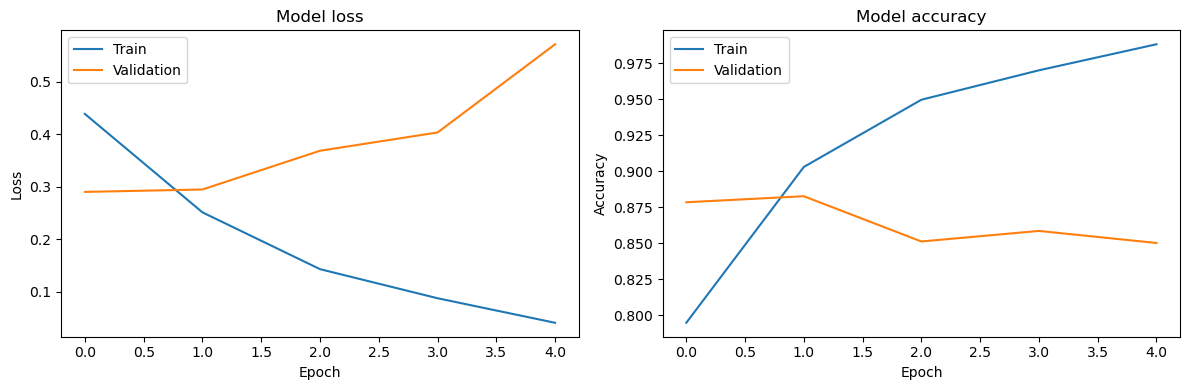

In [13]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')



plt.tight_layout()
plt.show()

The output indicates that the model is overfitting. The training accuracy is very high (reaching 99.42% by the end), while the validation accuracy is much lower (around 85%). Additionally, the validation loss is increasing while the training loss continues to decrease.

Add L2 regularization to your dense layers and Increase dropout rate to .5

In [14]:
from tensorflow.keras.regularizers import l2

def create_sbert_classification_model_with_l2(sbert_model,
                                              num_train_layers=0,
                                              hidden_size=200,
                                              dropout=0.3,
                                              learning_rate=0.00005,
                                              l2_lambda=0.01):
    """
    Build a classification model with SBERT and L2 regularization. Use the pooled output for classification.
    """
    # Get the name of the underlying model
    model_name = sbert_model._modules['0'].auto_model.config.name_or_path
    # Load the base model as a TensorFlow model
    bert_model = TFAutoModel.from_pretrained(model_name)
    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False
    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_model.trainable = True
    else:
        # Restrict training to the num_train_layers outer transformer layers
        for layer in bert_model.layers[:-num_train_layers]:
            layer.trainable = False
    
    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask')
    bert_outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = bert_outputs[1]
    
    # Add L2 regularization to the dense layers
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer',
                                   kernel_regularizer=l2(l2_lambda),
                                   bias_regularizer=l2(l2_lambda))(pooled_output)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)
    classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer',
                                           kernel_regularizer=l2(l2_lambda),
                                           bias_regularizer=l2(l2_lambda))(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics='accuracy')
    return classification_model

In [15]:
# Create classification model with L2 regularization
model_l2 = create_sbert_classification_model_with_l2(sbert_model, num_train_layers=3, l2_lambda=0.01)

# Train the model
history_l2 = model_l2.fit(
    [train_encodings['input_ids'], train_encodings['attention_mask']],
    train_labels,
    validation_split=0.2,
    epochs=10,
    batch_size=32
)

# Evaluate the model
test_loss_l2, test_accuracy_l2 = model_l2.evaluate([test_encodings['input_ids'], test_encodings['attention_mask']], test_labels)
print(f"Test accuracy (L2 regularized): {test_accuracy_l2}")

# Make predictions
predictions_l2 = model_l2.predict([test_encodings['input_ids'], test_encodings['attention_mask']])
predicted_labels_l2 = (predictions_l2 > 0.5).astype(int).flatten()

# Print classification report
from sklearn.metrics import classification_report
print("Classification Report (L2 regularized model):")
print(classification_report(test_labels, predicted_labels_l2))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/10
120/120 [==============================] - 735s 6s/step - loss: 2.8675 - accuracy: 0.8009 - val_loss: 2.5415 - val_accuracy: 0.8754
Epoch 2/10
120/120 [==============================] - 720s 6s/step - loss: 2.3204 - accuracy: 0.9101 - val_loss: 2.2524 - val_accuracy: 0.8639
Epoch 3/10
120/120 [==============================] - 720s 6s/step - loss: 1.9222 - accuracy: 0.9429 - val_loss: 1.9476 - val_accuracy: 0.8817
Epoch 4/10
120/120 [==============================] - 723s 6s/step - loss: 1.5741 - accuracy: 0.9730 - val_loss: 1.7547 - val_accuracy: 0.8754
Epoch 5/10
120/120 [==============================] - 722s 6s/step - loss: 1.3127 - accuracy: 0.9835 - val_loss: 1.6379 - val_accuracy: 0.8555
Epoch 6/10
120/120 [==============================] - 723s 6s/step - loss: 1.1005 - accuracy: 0.9843 - val_loss: 1.4586 - val_accuracy: 0.8660
Epoch 7/10
120/120 [==============================] - 724s 6s/step - loss: 0.8934 - accuracy: 0.9966 - val_loss: 1.3831 - val_accuracy: 0.8681

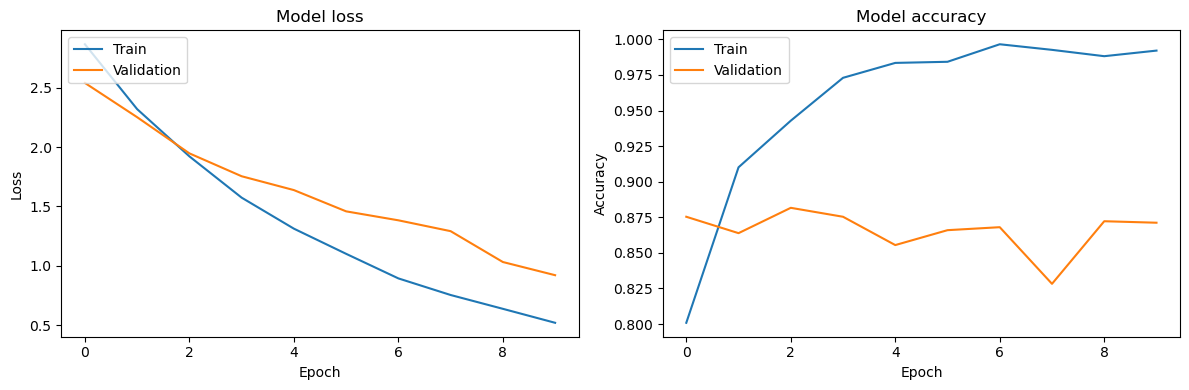

In [16]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_l2.history['loss'])
plt.plot(history_l2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history_l2.history['accuracy'])
plt.plot(history_l2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')



plt.tight_layout()
plt.show()

model with high dropout

In [17]:
def create_sbert_classification_model_with_increased_dropout(sbert_model,
                                                             num_train_layers=0,
                                                             hidden_size=200,
                                                             dropout=0.5,  # Increased from 0.3
                                                             learning_rate=0.00005,
                                                             l2_lambda=0.01):
    """
    Build a classification model with SBERT, L2 regularization, and increased dropout.
    """
    # Get the name of the underlying model
    model_name = sbert_model._modules['0'].auto_model.config.name_or_path
    # Load the base model as a TensorFlow model
    bert_model = TFAutoModel.from_pretrained(model_name)
    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False
    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_model.trainable = True
    else:
        # Restrict training to the num_train_layers outer transformer layers
        for layer in bert_model.layers[:-num_train_layers]:
            layer.trainable = False
    
    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask')
    bert_outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
    

    pooled_output = bert_outputs[1]
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer',
                                   kernel_regularizer=l2(l2_lambda),
                                   bias_regularizer=l2(l2_lambda))(pooled_output)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)
    
    # Add an additional dropout layer
    hidden = tf.keras.layers.Dropout(dropout)(hidden)
    
    classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer',
                                           kernel_regularizer=l2(l2_lambda),
                                           bias_regularizer=l2(l2_lambda))(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics='accuracy')
    return classification_model

    # ... (rest of the function remains unchanged)

# Create the model with increased dropout
model_high_dropout = create_sbert_classification_model_with_increased_dropout(sbert_model, num_train_layers=3)

# Train the model
history_high_dropout = model_high_dropout.fit(
    [train_encodings['input_ids'], train_encodings['attention_mask']],
    train_labels,
    validation_split=0.2,
    epochs=10,
    batch_size=32
)

# Evaluate the model
test_loss_high_dropout, test_accuracy_high_dropout = model_high_dropout.evaluate([test_encodings['input_ids'], test_encodings['attention_mask']], test_labels)
print(f"Test accuracy (high dropout): {test_accuracy_high_dropout}")

# Make predictions
predictions_high_dropout = model_high_dropout.predict([test_encodings['input_ids'], test_encodings['attention_mask']])
predicted_labels_high_dropout = (predictions_high_dropout > 0.5).astype(int).flatten()

# Print classification report
from sklearn.metrics import classification_report
print("Classification Report (high dropout model):")
print(classification_report(test_labels, predicted_labels_high_dropout))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/10
120/120 [==============================] - 736s 6s/step - loss: 2.9523 - accuracy: 0.7823 - val_loss: 2.6316 - val_accuracy: 0.8670
Epoch 2/10
120/120 [==============================] - 725s 6s/step - loss: 2.4179 - accuracy: 0.8897 - val_loss: 2.3068 - val_accuracy: 0.8450
Epoch 3/10
120/120 [==============================] - 725s 6s/step - loss: 2.0073 - accuracy: 0.9374 - val_loss: 2.0799 - val_accuracy: 0.8545
Epoch 4/10
120/120 [==============================] - 725s 6s/step - loss: 1.6784 - accuracy: 0.9610 - val_loss: 1.8526 - val_accuracy: 0.8691
Epoch 5/10
120/120 [==============================] - 728s 6s/step - loss: 1.3918 - accuracy: 0.9848 - val_loss: 1.7382 - val_accuracy: 0.8670
Epoch 6/10
120/120 [==============================] - 726s 6s/step - loss: 1.1830 - accuracy: 0.9848 - val_loss: 1.4398 - val_accuracy: 0.8534
Epoch 7/10
120/120 [==============================] - 726s 6s/step - loss: 1.0121 - accuracy: 0.9853 - val_loss: 1.5593 - val_accuracy: 0.8366

reduce learning rate, increase L2, reduce complexity

In [18]:
def create_sbert_classification_model_improved(sbert_model,
                                               num_train_layers=0,
                                               hidden_size=100,  # Reduced from 200
                                               dropout=0.5,
                                               learning_rate=0.00001,  # Reduced from 0.00005
                                               l2_lambda=0.1):  # Increased from 0.01
    """
    Build a classification model with SBERT, L2 regularization, and increased dropout.
    """
    # Get the name of the underlying model
    model_name = sbert_model._modules['0'].auto_model.config.name_or_path
    # Load the base model as a TensorFlow model
    bert_model = TFAutoModel.from_pretrained(model_name)
    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False
    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_model.trainable = True
    else:
        # Restrict training to the num_train_layers outer transformer layers
        for layer in bert_model.layers[:-num_train_layers]:
            layer.trainable = False
    
    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask')
    bert_outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
    

    pooled_output = bert_outputs[1]
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer',
                                   kernel_regularizer=l2(l2_lambda),
                                   bias_regularizer=l2(l2_lambda))(pooled_output)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)
    
    classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer',
                                           kernel_regularizer=l2(l2_lambda),
                                           bias_regularizer=l2(l2_lambda))(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipvalue=1.0)  # Add gradient clipping
    
    classification_model.compile(optimizer=optimizer,
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics=['accuracy'])
    return classification_model

# Create and train the improved model
model_improved = create_sbert_classification_model_improved(sbert_model, num_train_layers=3)

history_improved = model_improved.fit(
    [train_encodings['input_ids'], train_encodings['attention_mask']],
    train_labels,
    validation_split=0.2,
    epochs=15,  # Increased epochs to account for slower learning
    batch_size=32
)

# Evaluate the model
test_loss_improved, test_accuracy_improved = model_improved.evaluate(
    [test_encodings['input_ids'], test_encodings['attention_mask']], 
    test_labels
)
print(f"Test accuracy (improved model): {test_accuracy_improved}")

# Make predictions
predictions_improved = model_improved.predict(
    [test_encodings['input_ids'], test_encodings['attention_mask']]
)
predicted_labels_improved = (predictions_improved > 0.5).astype(int).flatten()

# Print classification report
from sklearn.metrics import classification_report
print("Classification Report (improved model):")
print(classification_report(test_labels, predicted_labels_improved))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/15
120/120 [==============================] - 751s 6s/step - loss: 16.5068 - accuracy: 0.6296 - val_loss: 16.1165 - val_accuracy: 0.8356
Epoch 2/15
120/120 [==============================] - 737s 6s/step - loss: 15.7985 - accuracy: 0.8454 - val_loss: 15.4514 - val_accuracy: 0.8702
Epoch 3/15
120/120 [==============================] - 737s 6s/step - loss: 15.2205 - accuracy: 0.8863 - val_loss: 14.9506 - val_accuracy: 0.8733
Epoch 4/15
120/120 [==============================] - 737s 6s/step - loss: 14.7039 - accuracy: 0.9025 - val_loss: 14.4819 - val_accuracy: 0.8723
Epoch 5/15
120/120 [==============================] - 738s 6s/step - loss: 14.2114 - accuracy: 0.9167 - val_loss: 14.0462 - val_accuracy: 0.8670
Epoch 6/15
120/120 [==============================] - 737s 6s/step - loss: 13.7338 - accuracy: 0.9345 - val_loss: 13.6079 - val_accuracy: 0.8723
Epoch 7/15
120/120 [==============================] - 737s 6s/step - loss: 13.2719 - accuracy: 0.9468 - val_loss: 13.2092 - val_ac

Overfitting: The training accuracy is still increasing to very high levels (0.9859 by epoch 14) while the validation accuracy plateaus and then decreases. This indicates that the model is still overfitting to the training data.
Validation accuracy decrease: The decrease in validation accuracy after epoch 5 suggests that the model starts to overfit more severely at this point. This is a clear sign that we should stop training earlier.
High loss values: The loss values are unusually high, which might indicate an issue with the loss calculation or scaling.

To address these issues, we can try the following:

Implement early stopping: This will automatically stop training when the validation accuracy starts to decrease.
Further reduce model complexity: We can decrease the hidden size even more and possibly remove one of the dropout layers.
Adjust the L2 regularization: The current value might be too high, causing the unusually high loss values.
Check the loss calculation: Ensure that the loss is being calculated correctly, especially considering the high values.

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

def create_sbert_classification_model_improved(sbert_model,
                                               num_train_layers=0,
                                               hidden_size=50,  # Further reduced from 100
                                               dropout=0.5,
                                               learning_rate=0.00001,
                                               l2_lambda=0.01):  # Reduced from 0.1
    """
    Build a classification model with SBERT, L2 regularization, and increased dropout.
    """
    # Get the name of the underlying model
    model_name = sbert_model._modules['0'].auto_model.config.name_or_path
    # Load the base model as a TensorFlow model
    bert_model = TFAutoModel.from_pretrained(model_name)
    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False
    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_model.trainable = True
    else:
        # Restrict training to the num_train_layers outer transformer layers
        for layer in bert_model.layers[:-num_train_layers]:
            layer.trainable = False
    
    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask')
    bert_outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
    

    pooled_output = bert_outputs[1]
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer',
                                   kernel_regularizer=l2(l2_lambda),
                                   bias_regularizer=l2(l2_lambda))(pooled_output)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)
    # Removed one dropout layer
    
    classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer',
                                           kernel_regularizer=l2(l2_lambda),
                                           bias_regularizer=l2(l2_lambda))(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipvalue=1.0)
    
    classification_model.compile(optimizer=optimizer,
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics=['accuracy'])
    return classification_model

# Create the improved model
model_improved = create_sbert_classification_model_improved(sbert_model, num_train_layers=3)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Train the model
history_improved = model_improved.fit(
    [train_encodings['input_ids'], train_encodings['attention_mask']],
    train_labels,
    validation_split=0.2,
    epochs=20,  # Increased max epochs, but early stopping will likely end training earlier
    batch_size=32,
    callbacks=[early_stopping]
)

# Evaluate and analyze as before

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20
120/120 [==============================] - 746s 6s/step - loss: 1.5082 - accuracy: 0.6555 - val_loss: 1.2917 - val_accuracy: 0.8482
Epoch 2/20
120/120 [==============================] - 735s 6s/step - loss: 1.2420 - accuracy: 0.8559 - val_loss: 1.1721 - val_accuracy: 0.8649
Epoch 3/20
120/120 [==============================] - 731s 6s/step - loss: 1.1621 - accuracy: 0.8879 - val_loss: 1.1430 - val_accuracy: 0.8723
Epoch 4/20
120/120 [==============================] - 734s 6s/step - loss: 1.0942 - accuracy: 0.9046 - val_loss: 1.1233 - val_accuracy: 0.8743
Epoch 5/20
120/120 [==============================] - 734s 6s/step - loss: 1.0357 - accuracy: 0.9243 - val_loss: 1.1406 - val_accuracy: 0.8670
Epoch 6/20
120/120 [==============================] - 735s 6s/step - loss: 0.9920 - accuracy: 0.9340 - val_loss: 1.1055 - val_accuracy: 0.8785
Epoch 7/20
120/120 [==============================] - 701s 6s/step - loss: 0.9367 - accuracy: 0.9518 - val_loss: 1.1099 - val_accuracy: 0.8712

Stabilize the training process (BatchNormalization).
Stop training earlier when validation accuracy starts to decrease (reduced early stopping patience).
Fine-tune the learning rate as training progresses (ReduceLROnPlateau).

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization

In [21]:
def create_sbert_classification_model_improved(sbert_model,
                                               num_train_layers=0,
                                               hidden_size=50,
                                               dropout=0.5,
                                               learning_rate=0.00001,
                                               l2_lambda=0.01):
    """
    Build a classification model with SBERT, L2 regularization, and increased dropout.
    """
    # Get the name of the underlying model
    model_name = sbert_model._modules['0'].auto_model.config.name_or_path
    # Load the base model as a TensorFlow model
    bert_model = TFAutoModel.from_pretrained(model_name)
    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False
    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_model.trainable = True
    else:
        # Restrict training to the num_train_layers outer transformer layers
        for layer in bert_model.layers[:-num_train_layers]:
            layer.trainable = False
    
    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask')
    bert_outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)

    pooled_output = bert_outputs[1]
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer',
                                   kernel_regularizer=l2(l2_lambda),
                                   bias_regularizer=l2(l2_lambda))(pooled_output)
    hidden = BatchNormalization()(hidden)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)
    
    classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer',
                                           kernel_regularizer=l2(l2_lambda),
                                           bias_regularizer=l2(l2_lambda))(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipvalue=1.0)
    
    classification_model.compile(optimizer=optimizer,
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics=['accuracy'])
    return classification_model

# Create the improved model
model_improved = create_sbert_classification_model_improved(sbert_model, num_train_layers=3)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-6)

# Train the model
history_improved = model_improved.fit(
    [train_encodings['input_ids'], train_encodings['attention_mask']],
    train_labels,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate and analyze as before

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20
120/120 [==============================] - 543s 4s/step - loss: 1.5262 - accuracy: 0.6764 - val_loss: 1.5343 - val_accuracy: 0.8000 - lr: 1.0000e-05
Epoch 2/20
120/120 [==============================] - 536s 4s/step - loss: 1.3024 - accuracy: 0.8263 - val_loss: 1.4123 - val_accuracy: 0.8681 - lr: 1.0000e-05
Epoch 3/20
120/120 [==============================] - 581s 5s/step - loss: 1.2263 - accuracy: 0.8669 - val_loss: 1.2993 - val_accuracy: 0.8775 - lr: 1.0000e-05
Epoch 4/20
120/120 [==============================] - 697s 6s/step - loss: 1.1746 - accuracy: 0.8873 - val_loss: 1.2036 - val_accuracy: 0.8754 - lr: 1.0000e-05
Epoch 5/20
120/120 [==============================] - 679s 6s/step - loss: 1.1422 - accuracy: 0.8973 - val_loss: 1.1653 - val_accuracy: 0.8775 - lr: 1.0000e-05


In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Dense

def create_sbert_classification_model_improved(sbert_model,
                                               num_train_layers=0,
                                               hidden_size=64,  # Slightly increased
                                               dropout=0.4,     # Slightly reduced
                                               learning_rate=0.00002,  # Slightly increased
                                               l2_lambda=0.005):  # Slightly reduced
    
    model_name = sbert_model._modules['0'].auto_model.config.name_or_path
    # Load the base model as a TensorFlow model
    bert_model = TFAutoModel.from_pretrained(model_name)
    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False
    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_model.trainable = True
    else:
        # Restrict training to the num_train_layers outer transformer layers
        for layer in bert_model.layers[:-num_train_layers]:
            layer.trainable = False
    
    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask')
    bert_outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)


    pooled_output = bert_outputs[1]
    hidden = Dense(hidden_size, activation='relu', name='hidden_layer',
                   kernel_regularizer=l2(l2_lambda),
                   bias_regularizer=l2(l2_lambda))(pooled_output)
    hidden = BatchNormalization()(hidden)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)
    
    # Add another dense layer
    hidden = Dense(32, activation='relu', name='hidden_layer_2',
                   kernel_regularizer=l2(l2_lambda),
                   bias_regularizer=l2(l2_lambda))(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)
    
    classification = Dense(1, activation='sigmoid', name='classification_layer',
                           kernel_regularizer=l2(l2_lambda),
                           bias_regularizer=l2(l2_lambda))(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipvalue=0.5)  # Reduced clipvalue
    
    classification_model.compile(optimizer=optimizer,
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics=['accuracy'])
    return classification_model

# Create the improved model
model_improved = create_sbert_classification_model_improved(sbert_model, num_train_layers=3)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6, verbose=1)

# Train the model
history_improved = model_improved.fit(
    [train_encodings['input_ids'], train_encodings['attention_mask']],
    train_labels,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate and analyze as before

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20
120/120 [==============================] - 724s 6s/step - loss: 1.4438 - accuracy: 0.6628 - val_loss: 1.3588 - val_accuracy: 0.7173 - lr: 2.0000e-05
Epoch 2/20
120/120 [==============================] - 695s 6s/step - loss: 1.1902 - accuracy: 0.8143 - val_loss: 1.2517 - val_accuracy: 0.8115 - lr: 2.0000e-05
Epoch 3/20
120/120 [==============================] - 690s 6s/step - loss: 1.1176 - accuracy: 0.8609 - val_loss: 1.1324 - val_accuracy: 0.8482 - lr: 2.0000e-05
Epoch 4/20
120/120 [==============================] - 679s 6s/step - loss: 1.0605 - accuracy: 0.8774 - val_loss: 1.0806 - val_accuracy: 0.8607 - lr: 2.0000e-05
Epoch 5/20
120/120 [==============================] - 706s 6s/step - loss: 1.0208 - accuracy: 0.9007 - val_loss: 1.0571 - val_accuracy: 0.8733 - lr: 2.0000e-05
Epoch 6/20
120/120 [==============================] - ETA: 0s - loss: 0.9892 - accuracy: 0.9180
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
120/120 [===================